<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit NPL Classfication Challenge
Notebook 2: Data Cleaning & EDA

This notebook contains all the preparational steps before modeling as follow:

- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis & Visualizations](#Exploratory-Data-Analysis-&-Visualizations)
- [Preprocessing](#Preprocessing)

The results of this notebook is a dataset that is ready for modeling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

In [3]:
jokes = pd.read_csv('../data/jokes.csv')
jokes.head()
tales = pd.read_csv('../data/talesfromretail.csv')
tales.head()

,author,title,selftext,score,num_comments,upvote_ratio,created_utc,subreddit
0,NormalDeviance,Fitting rooms are disgusting,"This isn’t so much of a single story, but more...",1,7,1.0,1602294153,TalesFromRetail
1,NormalDeviance,Trying to return year-old worn shoes,Worked at a major department store at the retu...,1,12,1.0,1602288304,TalesFromRetail
2,MaryCranberry,A cashier witnesses true love,I’m a cashier at a store at a ski resort. We h...,1,60,1.0,1602285068,TalesFromRetail
3,tempthethrowaway,Follow My Brownies,"This is my wife's story from today, posted wit...",1,23,1.0,1602283980,TalesFromRetail
4,[deleted],Customer is totally friends with a manager fro...,NaN,1,0,1.0,1602268197,TalesFromRetail


In [4]:
print(f'Jokes shape {jokes.shape}')
print(f'Tales shape {tales.shape}')

Jokes shape (9526, 8)
Tales shape (9434, 8)


### Data Cleaning

Data Cleaning session include checking the null values and data types. For each step I tried to code both subreddits in the same cell as much as possible to track the changes made easily.

#### Check & Process Null Values

In [5]:
jokes.isnull().sum()

author          0
title           0
selftext        3
score           0
num_comments    0
upvote_ratio    0
created_utc     0
subreddit       0
dtype: int64

In [6]:
tales.isnull().sum()

author             0
title              0
selftext           2
score              0
num_comments       0
upvote_ratio    8573
created_utc        0
subreddit          0
dtype: int64

For jokes, all columns are complete except for 3 null values in selftext. However for tales, aside from the null values in selftext, it's also lacking a great amount of upvote_ratio. I therefore decided to drop the upvote_ratio columns. As for the selftext, I would like to examine if the NaN is because all the post content is already in the title. To be able to review the entire text, I set up the display option to max column width.

In [7]:
tales.drop(columns = 'upvote_ratio', inplace = True)
jokes.drop(columns = 'upvote_ratio', inplace = True)

In [8]:
pd.set_option('display.max_colwidth', 0)

In [9]:
jokes[jokes['selftext'].isnull()]

,author,title,selftext,score,num_comments,created_utc,subreddit
440,[deleted],I was trying to have a civil discussion with people about my dihorrhea,NaN,1,0,1602219906,Jokes
1598,zozkcbsj--zhz,He was just trying to help...,NaN,1,0,1602008180,Jokes
8557,Sharkie_PIxel,[OC] Guys I have the only original joke!,NaN,1,0,1600584961,Jokes


The above three posts don't seem to be a complete joke by the title itself. Therefore I decided to drop these posts.

In [10]:
tales[tales['selftext'].isnull()]

,author,title,selftext,score,num_comments,created_utc,subreddit
4,[deleted],Customer is totally friends with a manager from another department,NaN,1,0,1602268197,TalesFromRetail
180,PlasmaCarrot79,Super Soaker,NaN,1,0,1598471414,TalesFromRetail


Same as jokes, these posts are also not complete tales and therefore should be dropped.

In [11]:
jokes.drop([440, 1598, 8557], inplace = True)
tales.drop([4, 180], inplace =True)

As I was dropping the NaN, I noticed author and selftext column could also contain "deleted". I then looked into how many these posts are.

In [12]:
jokes[jokes.author == '[deleted]']
tales[tales.author == '[deleted]']

,author,title,selftext,score,num_comments,created_utc,subreddit
218,[deleted],Changing room horror story,[deleted],1,0,1597791303,TalesFromRetail


Luckily there are only a couple in each subreddit, which will not impact my dataset that much. So I decided to drop these as well.

In [13]:
jokes.drop(33, inplace = True)
tales.drop(218, inplace = True)

In [14]:
jokes[jokes.selftext == '[deleted]']
tales[tales.selftext == '[deleted]']

,author,title,selftext,score,num_comments,created_utc,subreddit


Double check if there are any other "deleted" posts. I found none as of now. So I think we are good here.

In [15]:
print(f'Jokes shape {jokes.shape}')
print(f'Tales shape {tales.shape}')

Jokes shape (9522, 7)
Tales shape (9431, 7)


#### Check Data Types

In [16]:
jokes.dtypes
tales.dtypes

author          object
title           object
selftext        object
score           int64 
num_comments    int64 
created_utc     int64 
subreddit       object
dtype: object

Data types for both subreddits look normal. No changes needed at this point.

#### Reset Index

As I dropped a couple posts, it's always good practice to reset the index to ensure consistancy.

In [17]:
jokes.reset_index(drop = True, inplace = True)
tales.reset_index(drop = True, inplace = True)

### Feature Engineering

In this part, I engineered some features in preparation for the EDA. To start with, I created new columns of text which concatnate the title and selftext columns together. I did this because for many posts there is not a clear line between the title and selftext. And since we are examing the content, it's a better idea to combine these two columns. After length and word count which count the character numbers and word number of title and self text combined. 

In [18]:
jokes['text'] = jokes['title'] + ' ' + jokes['selftext']
tales['text'] = tales['title'] + ' ' + tales['selftext']

I then created two columns which sums up the character counts and word counts of each post.

In [19]:
jokes['char_count'] = [len(i) for i in jokes['text']]
tales['char_count'] = [len(i) for i in tales['text']]

In [20]:
jokes['word_count'] = [len(i.split()) for i in jokes['text']]
tales['word_count'] = [len(i.split()) for i in tales['text']]

I then created an age column by subtracting the datetime the post was created from the datetime the post was retrieved(10/17/2020 Midnight PDT). I used [Epoch Converter](https://www.epochconverter.com) to get the UTC timestamp and used dateime library to convert the timestamp back to datetime.

In [20]:
from datetime import datetime

In [21]:
# credit to https://stackoverflow.com/questions/3743222/how-do-i-convert-a-datetime-to-date
# credit to https://www.programiz.com/python-programming/datetime/timestamp-datetime

jokes['created_utc'] = [datetime.fromtimestamp(i) for i in jokes['created_utc']]
tales['created_utc'] = [datetime.fromtimestamp(i) for i in tales['created_utc']]

In [22]:
jokes['retrieved']= datetime.fromtimestamp(1602918000) # 10/17/2020 00:00:00 PDT
tales['retrieved']= datetime.fromtimestamp(1602918000)

In [23]:
jokes['age'] = (jokes.retrieved - jokes.created_utc)
tales['age'] = (tales.retrieved - tales.created_utc)

Here I got the datetime value of age however I decided to fomrat them into days for more straightforward review.

In [24]:
# credit https://stackoverflow.com/questions/2119472/convert-a-timedelta-to-days-hours-and-minutes

jokes['age'] = [i.days for i in jokes['age']]
tales['age'] = [i.days for i in tales['age']]

### Exploratory Data Analysis & Visualizations

Although conducting natural language processing to classify posts, EDA is still necessary for datasets. The goal of EDA here is mainly to help put the data in context so that I can better understand the data so that I could have insights in the modeling and intepretation stage. Also because of this, I conducted the EDA separately for each subreddit first and then look at the visualizations of both subreddits together.

#### Jokes Subreddit

In [25]:
jokes.score.describe()

count    9522.000000
mean     1.134846   
std      1.439493   
min      0.000000   
25%      1.000000   
50%      1.000000   
75%      1.000000   
max      104.000000 
Name: score, dtype: float64

Initially I included the score so that I can understand what posts in each subreddit I'm examining are most welcomed by reddit users. However, Pushlift had an [update](https://www.reddit.com/r/pushshift/comments/ha7935/score_of_a_comment_always_equal_to_1/) about a year ago and now the API only stores the scores at the time it accessed and does not update after. Therefore I have a lot of 1 in score, which does not provide any references. Considering I also have number of comments column that I assume are correlated to the popularity of a post, I decided to drop the score feature from my dataset.

In [26]:
jokes.num_comments.describe()

count    9522.000000
mean     6.393195   
std      47.729355  
min      0.000000   
25%      0.000000   
50%      1.000000   
75%      3.000000   
max      1821.000000
Name: num_comments, dtype: float64

Most posts from jokes receive 0 to 3 comments. Next I would like to examine those posts with most comments. 

In [27]:
jokes.num_comments.sort_values(ascending = False)[:5]

3689    1821
7250    1738
3203    1195
859     1099
8369    1055
Name: num_comments, dtype: int64

In [28]:
jokes[(jokes.num_comments == 1821) | (jokes.num_comments == 1738) | (jokes.num_comments == 1195) 
      | (jokes.num_comments == 1099) | (jokes.num_comments == 1055)]

,author,title,selftext,score,num_comments,created_utc,subreddit,text,char_count,word_count,retrieved,age
859,MaxQ50,Smartest president,"An airplane was about to crash. There were 4 passengers on board, but only 3 parachutes.\n\nThe 1st passenger said, 'I am LeBron James, the best NBA basketball player. The Lakers and my millions of fans need me, and I can't afford to die.' So he took the 1st pack and left the plane.\n\nThe 2nd passenger, Donald Trump, said, 'I am the US President, and I am the smartest President in American history, so my people don't want me to die.' He took the 2nd pack and jumped out of the plane.\n\nThe 3rd passenger, the Pope, said to the 4th passenger, a 10-year-old schoolboy, 'My son, I am old and don't have many years left, you have more years ahead so I will sacrifice my life and let you have the last parachute.'\n\nThe little boy said, 'That's okay, Your Holiness, there's a parachute left for you. America 's smartest President took my schoolbag...",1,1099,2020-10-08 04:17:24,Jokes,"Smartest president An airplane was about to crash. There were 4 passengers on board, but only 3 parachutes.\n\nThe 1st passenger said, 'I am LeBron James, the best NBA basketball player. The Lakers and my millions of fans need me, and I can't afford to die.' So he took the 1st pack and left the plane.\n\nThe 2nd passenger, Donald Trump, said, 'I am the US President, and I am the smartest President in American history, so my people don't want me to die.' He took the 2nd pack and jumped out of the plane.\n\nThe 3rd passenger, the Pope, said to the 4th passenger, a 10-year-old schoolboy, 'My son, I am old and don't have many years left, you have more years ahead so I will sacrifice my life and let you have the last parachute.'\n\nThe little boy said, 'That's okay, Your Holiness, there's a parachute left for you. America 's smartest President took my schoolbag...",864,158,2020-10-17,8
3203,Firetrock,Trump might finally get what he wants the most,He might get to be president for the rest of his life.,1,1195,2020-10-02 17:46:15,Jokes,Trump might finally get what he wants the most He might get to be president for the rest of his life.,101,21,2020-10-17,14
3689,IAmGoingToBeSerious,Trump tests positive for COVID-19.,"He finally passed a test without cheating, good for him.",1,1821,2020-10-01 22:32:36,Jokes,"Trump tests positive for COVID-19. He finally passed a test without cheating, good for him.",91,15,2020-10-17,15
7250,cyclopropagative,"I’m American, and I’m sick of people saying America is “the stupidest country in the world.”","Personally, I think Europe is the stupidest country in the world.",1,1738,2020-09-23 04:40:25,Jokes,"I’m American, and I’m sick of people saying America is “the stupidest country in the world.” Personally, I think Europe is the stupidest country in the world.",158,27,2020-10-17,23
8369,IdeaCafe,CAN ADMINS OF THIS SUBREDDIT REDDIT DO A BETTER JOB OF MONITORING WHO IS ALLOWED IN HERE PLEASE?!,"WE HAVE A NEW MEMBER, A WOMAN. SHE’S BEEN PRIVATELY MESSAGING MEMBERS, SENDING THEM NAKED PICTURES OF HERSELF IN NASTY POSES ALONG WITH CLOSE UPS OF HER UNMENTIONABLES. SHE IS OFFERING AN IPHONE 8+ IN EXCHANGE FOR SEXUAL FAVORS. I AM ESPECIALLY BOTHERED BECAUSE IT TURNED OUT TO BE AN IPHONE 6 AND OBVIOUSLY SOMETHING'S WRONG WITH IT. IT'S SUPER SLOW AND THE CAPS LOCK IS STUCK ON.",1,1055,2020-09-20 09:41:27,Jokes,"CAN ADMINS OF THIS SUBREDDIT REDDIT DO A BETTER JOB OF MONITORING WHO IS ALLOWED IN HERE PLEASE?! WE HAVE A NEW MEMBER, A WOMAN. SHE’S BEEN PRIVATELY MESSAGING MEMBERS, SENDING THEM NAKED PICTURES OF HERSELF IN NASTY POSES ALONG WITH CLOSE UPS OF HER UNMENTIONABLES. SHE IS OFFERING AN IPHONE 8+ IN EXCHANGE FOR SEXUAL FAVORS. I AM ESPECIALLY BOTHERED BECAUSE IT TURNED OUT TO BE AN IPHONE 6 AND OBVIOUSLY SOMETHING'S WRONG WITH IT. IT'S SUPER SLOW AND THE CAPS LOCK IS STUCK ON.",479,86,2020-10-17,26


Of all the top 5 posts with most comments, 3 of them are about or mentioned Trump or American president.

#### TalesFromRetail Subreddit

In [29]:
tales.num_comments.describe()

count    9431.000000
mean     24.938395  
std      47.166440  
min      0.000000   
25%      0.000000   
50%      7.000000   
75%      25.000000  
max      591.000000 
Name: num_comments, dtype: float64

The spread of tales is smaller than jokes, with most number of comments under 25 and the max number of 591. Let's also take a look at the top 5 most commented posts from tales.

In [30]:
tales.num_comments.sort_values(ascending = False)[:5]

7850    591
8470    528
7433    527
2765    502
1210    464
Name: num_comments, dtype: int64

In [31]:
tales[(tales.num_comments == 591) | (tales.num_comments == 528) | (tales.num_comments == 527) 
      | (tales.num_comments == 502) | (tales.num_comments == 464)]

,author,title,selftext,score,num_comments,created_utc,subreddit,text,char_count,word_count,retrieved,age
1210,TrappedWithTheKey,At this point I should just start making a weekly post about things people say when I ask for ID for cigarettes...,"Quick background, since Jan 1st, my state increased the minimum age for tobacco purchase to 21. Every gas station in my local area now requires everyone, regardless of age at all, to show a valid ID to discourage the already ongoing issue of purchasing for underage people.\n\nHere's another recent one from the other day: (M=me, C=customer)\n\nC: Marlboro 100s too\n\nM: sure, we do need to ask for ID too.\n\nC: what? Dide I'm like twice your age...\n\nM: I'm still required to as part of my job, I completely get the frustration though... *(I've found that appearing sympathetic to a certain point can avoid issues sometimes, but not always...)*\n\nC: yeah, I guess you conveniently forgot to card the pretty little white girl a minute ago huh?\n\nM: actually, she had just come back in after getting her ID since she left it in the car and I couldnt sell it to her otherwise. Again, I get it, but I still need to card everyone regardless if they're 21 or 121.\n\nC: fuck outta here, I'm going up the road then for the cigs\n\nM: just the gas then today? *puts cigs back in slot*\n\nC: *(obviously dumbfounded)* you really are gonna be a little bitch about it aren't you? You're lucky if I dont decide to sue you discrimination of age or attempting to steal identity information...\n\nM: *(seriously irritated and theres a line forming which isn't helping the stress at this point)* sir, I gotta do my job regardless, if you REALLY feel inclined to do so, I cant legally try to stop you, but for now, if you're still getting gas, please let me know... I dont mean to sound rude but I'm the only one with a register open and theres a line forming...\n\nC: right, now you're just being a dumbass, but Its cool, college isn't for everyone I guess\n\nM: *(internally fuming at this point)* ...$25....\n\nC: nah I'll just get the gas up the road\n\nM: *hits void* understandable, enjoy the rest of the day though!\n\nC: what, you thought I was serious? $25 on 9 still.\n\nThankfully he shut up until he got to the door after finally pre-paid for the gas... then blurted out that the company should be recognized for employing special ed kids. He was banned from the property after being caught giving 2 others a hard time like that too. Once during the next shift after me, and once the following day to my manager directly... \n\nWhat do people honestly think they'll accomplish acting like that anyway?",1,464,2020-02-28 00:58:54,TalesFromRetail,"At this point I should just start making a weekly post about things people say when I ask for ID for cigarettes... Quick background, since Jan 1st, my state increased the minimum age for tobacco purchase to 21. Every gas station in my local area now requires everyone, regardless of age at all, to show a valid ID to discourage the already ongoing issue of purchasing for underage people.\n\nHere's another recent one from the other day: (M=me, C=customer)\n\nC: Marlboro 100s too\n\nM: sure, we do need to ask for ID too.\n\nC: what? Dide I'm like twice your age...\n\nM: I'm still required to as part of my job, I completely get the frustration though... *(I've found that appearing sympathetic to a certain point can avoid issues sometimes, but not always...)*\n\nC: yeah, I guess you conveniently forgot to card the pretty little white girl a minute ago huh?\n\nM: actually, she had just come back in after getting her ID since she left it in the car and I couldnt sell it to her otherwise. Again, I get it, but I still need to card everyone regardless if they're 21 or 121.\n\nC: fuck outta here, I'm going up the road then for the cigs\n\nM: just the gas then today? *puts cigs back in slot*\n\nC: *(obviously dumbfounded)* you really are gonna be a little bitch about it aren't you? You're lucky if I d

The top 5 commented posts in tales from retail are all centered around complaints about customers which don't intend to be funny.

### Visualizations

Now let's take a look at the distribution of two subreddits.

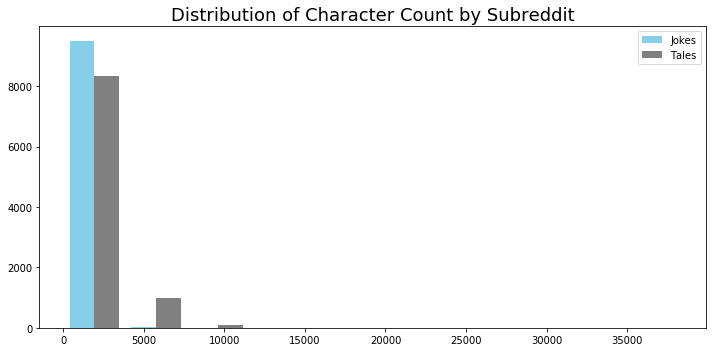

In [56]:
# credit to Hov's NLP EDA

plt.figure(figsize = (10, 5))
plt.hist([jokes['char_count'], 
          tales['char_count']],
         bins = 10, color = ['skyblue', 'grey'])
plt.title('Distribution of Character Count by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/dist_of_char_count');

The histogram above shows that character counts of jokes are more concentrated in the lower end while tales are more spreaded in higher number counts.

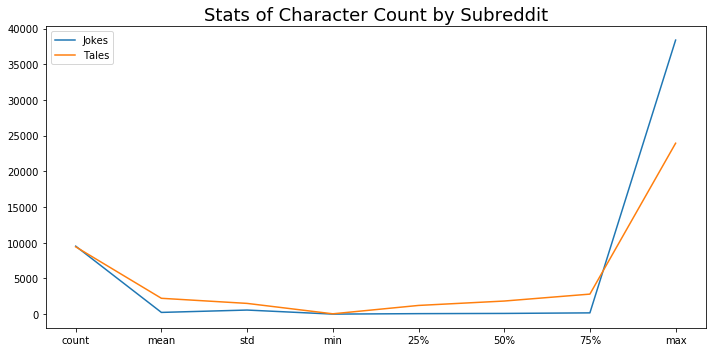

In [57]:
plt.figure(figsize = (10, 5))
jokes.char_count.describe().plot()
tales.char_count.describe().plot()
plt.title('Stats of Character Count by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/stats_of_char_count');

The above line chart also shows that jokes has the larger maximum character count between two subreddits however most of jokes posts have lower character counts than tales.

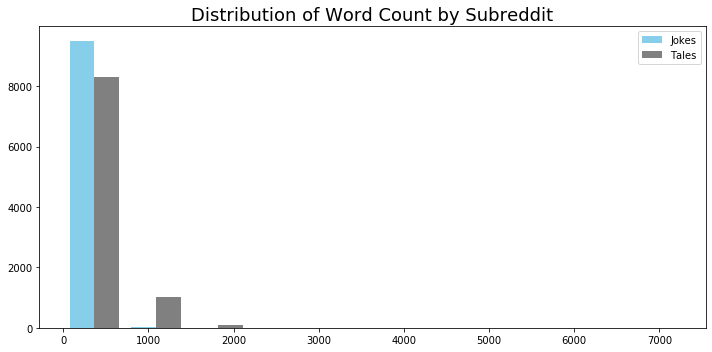

In [58]:
plt.figure(figsize = (10, 5))
plt.hist([jokes['word_count'], 
          tales['word_count']],
         bins = 10, color = ['skyblue', 'grey'])
plt.title('Distribution of Word Count by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/dist_of_word_count');

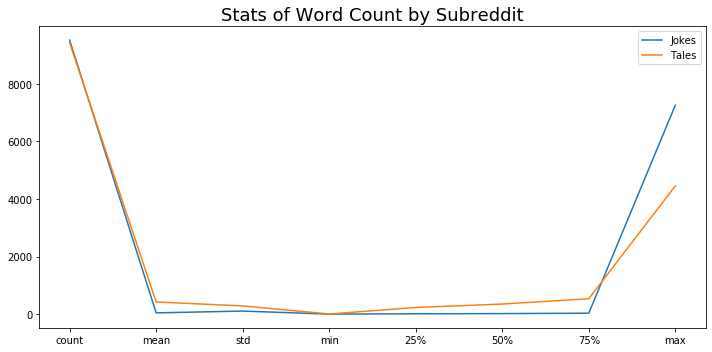

In [60]:
plt.figure(figsize = (10, 5))
jokes.word_count.describe().plot()
tales.word_count.describe().plot()
plt.title('Stats of Word Count by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/stats_of_word_count');

Similar as word count, jokes also have the larger of max word counts however average is lower than tales. This indicates that tales posts in general are longer than jokes.

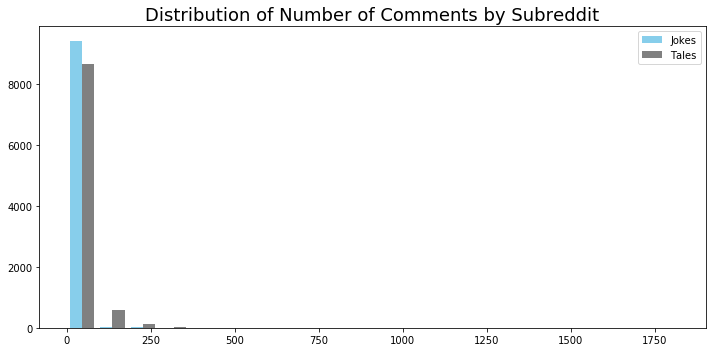

In [61]:
plt.figure(figsize = (10, 5))
plt.hist([jokes.num_comments,
        tales.num_comments],
        bins = 20, color = ['skyblue', 'grey'])
plt.title('Distribution of Number of Comments by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/dist_of_num_of_comments_count');

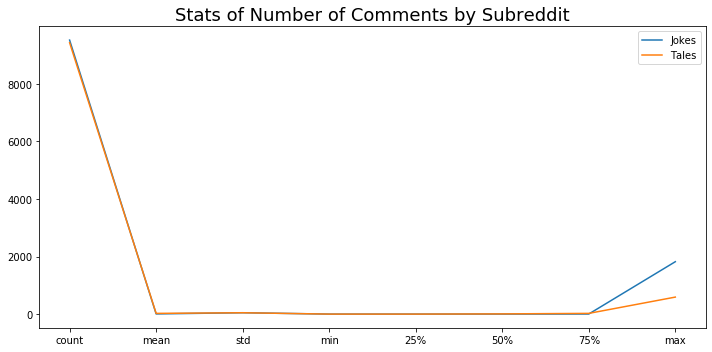

In [63]:
plt.figure(figsize = (10, 5))
jokes.num_comments.describe().plot()
tales.num_comments.describe().plot()
plt.title('Stats of Number of Comments by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/stats_of_num_of_comments_count');

The number of comments for both subreddits are mostly similar, however in the high range (over 500 comments range), jokes have more comments than tales.

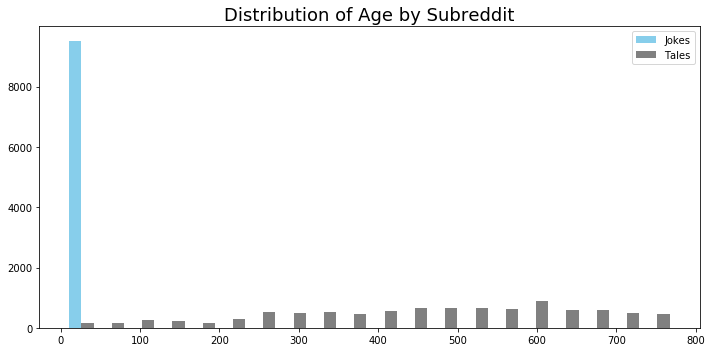

In [64]:
plt.figure(figsize = (10, 5))
plt.hist([jokes.age,
        tales.age],
        bins = 20, color = ['skyblue', 'grey'])
plt.title('Distribution of Age by Subreddit', fontsize = 18)
plt.legend(['Jokes', 'Tales'])
plt.tight_layout()
plt.savefig('../charts/dist_of_age_count');

As indicated by the histogram above, jokes latest legit posts are mostly in the past month, however for the tales, the posts go way back to more than 2 years ago. This means that that jokes subreddit has a lot more active postings than tales.

### Preprocessing

After the basic EDA, it's time to finally combine two datasets together for Natural Language Processing. I only kept text and subreddit groups for this purpose. Also please note that this preprocessing is for exploratory purposes, not for modeling. That's why no train test split is done.

In [39]:
df = pd.concat([jokes, tales])

df = df[['subreddit', 'text']].copy()

# reset index after combine
df.reset_index(drop = True, inplace = True)

df.shape

(18953, 2)

In [40]:
df['text'].iloc[2:4]

2    An old man walks into the barbershop for a shave and a haircut He asks the barber, "do you think you can get all my whiskers off? My cheeks are so wrinkled from age". \n\nThe barber gets a little wooden ball from a cup on the shelf and tells him to put it inside his cheek to spread out the skin. \n\nWhen he's finished, the old man tells the barber that was the cleanest shave he's had in years. But he wanted to know what would have happened if he had swallowed that little ball. \n\nThe barber replied, "Just bring it back tomorrow like everyone else does".
3    I remember being a kid and my parents filling my head with nonsense like the Santa, Tooth fairy and Easter Bunny Well now that I'm older I don't fall for that rubbish anymore, thank God.                                                                                                                                                                                                                                                   

In [41]:
# export the combined clean data for later modeling
df.to_csv('../data/combined_for_npl.csv', index = False)

In [42]:
# make the target result binary where jokes subreddit will be 1, talesfromretail will be 0
df.subreddit = df.subreddit.map({'Jokes': 1,
                                'TalesFromRetail': 0})

#### Use CountVector without Stop Words

CountVectorizer by default only vectorizes words with two letters or more, which means I will not be included as a vector target. In this project since posts from talesfromretail are usually personal stories that start with "I work...", I believe "I" need to be included. That's why I changed the token pattern to include all the one letter words too.

In [43]:
# instantiate # credit to my classmates Will, James, and Nadar helping me figure out the token pattern
# also credit to https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
cvec = CountVectorizer(token_pattern = u"(?u)\\b\\w+\\b")

# fit and transform
X = cvec.fit_transform(df['text'])

# create a new dataframe for all the vecotirzed words
reddit = pd.DataFrame(X.toarray(), columns = cvec.get_feature_names())

# check how many features I got
reddit.shape

(18953, 42192)

As I didn't set any hyperparameters, I ended up having whopping 42192 columns! This is definitely going to slow down my processing so I will have to optimize this in my next preprocessing.

In [44]:
# reinsert the target back to the dataframe
# credit to Hov's NLP EDA lecture
reddit.insert(0, 'sub_target', df['subreddit'])
reddit.head()

,sub_target,0,00,000,000000,000000001,000002,00015000048303,000nok,000s,...,𝒔,𝒔𝒐𝒎𝒆𝒕𝒊𝒎𝒆𝒔,𝗪𝗵𝗮𝘁,𝗮,𝗵𝗮𝘃𝗲,𝗶𝘁,𝗹𝗶𝗸𝗲,𝗽𝗲𝗻𝗶𝘀,𝘀,𝘁𝗼
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# find the top 20 words for both subreddits

jokes_top_word = reddit.groupby('sub_target').sum().T.sort_values(1, ascending=False).head(20)
tales_top_word = reddit.groupby('sub_target').sum().T.sort_values(0, ascending=False).head(20)

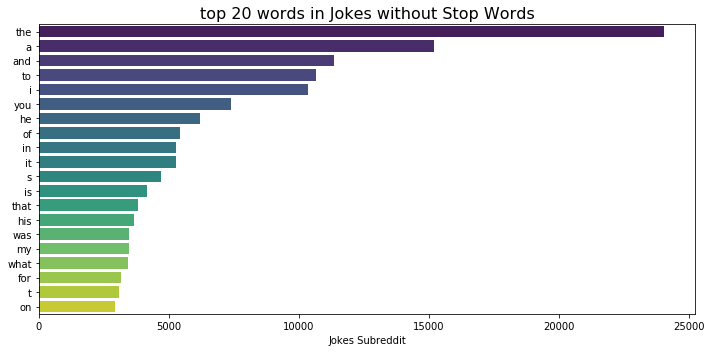

In [46]:
# visualize top 20 words in Jokes without using stop words

plt.figure(figsize = (10, 5))
sns.barplot(x = jokes_top_word[1], y = jokes_top_word.index, orient = 'h', palette = 'viridis')
plt.title('top 20 words in Jokes without Stop Words', fontsize = 16)
plt.xlabel('Jokes Subreddit')
plt.tight_layout()
plt.savefig('../charts/top_word_jokes_without_stop_words.png');

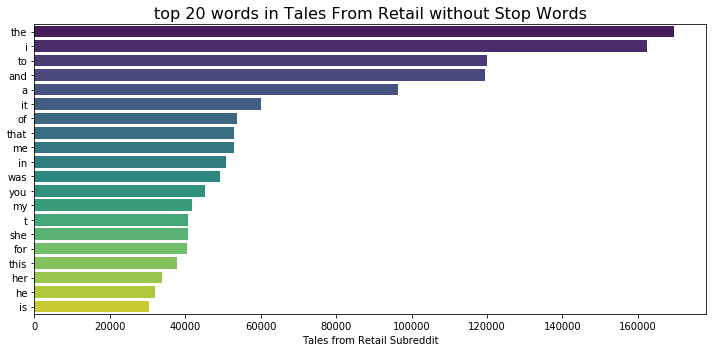

In [47]:
# visualize top 20 words in TalesfromRetail without using stop words

plt.figure(figsize = (10, 5))
sns.barplot(x = tales_top_word[0], y = tales_top_word.index, orient = 'h', palette = 'viridis')
plt.title('top 20 words in Tales From Retail without Stop Words', fontsize = 16)
plt.xlabel('Tales from Retail Subreddit')
plt.tight_layout()
plt.savefig('../charts/top_word_tales_without_stop_words.png');

From the above ranking , looks like the top words for both subreddits are mostly meaningless stop words. Therefore I would like to try using the stopwrods and see what changes it would make. In addition, as mentioned before the 42,000+ columns is taking way too long to process, so I would like to add min frequency and amx frequency to limit the feature numbers.

#### Use CountVector with Stop Words

I created my own stop words list by utilizing the sklearn built in stop words. I mainly did this to avoid removing "I", as for both nltk and sklearn, "I" is considered as a stop word. I also added other sinlge letter words as stop words to decrease noise. I understand by doing this, "I" might become one of the most frequent word in the list but since I mainly want to factor in phrases like "I work", "I worked" in my modeling stage, I won't worry too much about this.

In [48]:
# create a set of stop words based on the built-in list, except excluding "I"
stop = []
for word in ENGLISH_STOP_WORDS:
    if word != 'i':
        stop.append(word)
        
        
stop_words = set(stop).union('b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 
                              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                              'y', 'z', '_')

In [49]:
# this time added stop words in hyperparameter


cvec_stop = CountVectorizer(stop_words = stop_words,
                           token_pattern = u'(?u)\\b\\w+\\b',
                           min_df = 2,
                           max_df = .98)

X_stop = cvec_stop.fit_transform(df['text'])

reddit_stop = pd.DataFrame(X_stop.toarray(), columns = cvec_stop.get_feature_names())

reddit_stop.insert(0, 'sub_target', df['subreddit'])

reddit_stop.head()

,sub_target,0,00,000,00am,00pm,01,01ii5y2cy2rl,02,02pm,...,zoomed,zooming,zooms,zoos,zuckerberg,zzub,ø,π,ಠ_ಠ,ツ
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


23656 features, still a lot, but much better than 42,000+!

In [50]:
jokes_top_word_stop = reddit_stop.groupby('sub_target').sum().T.sort_values(1, ascending=False).head(20)
tales_top_word_stop = reddit_stop.groupby('sub_target').sum().T.sort_values(0, ascending=False).head(20)

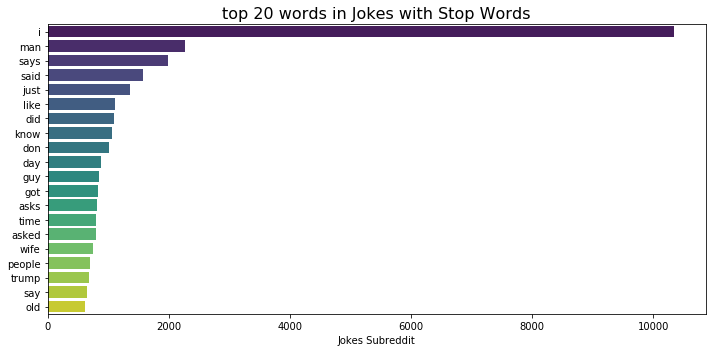

In [51]:
# visualize top 20 words in Jokes using stop words

plt.figure(figsize = (10, 5))
sns.barplot(x = jokes_top_word_stop[1], y = jokes_top_word_stop.index, orient = 'h', palette = 'viridis')
plt.title('top 20 words in Jokes with Stop Words', fontsize = 16)
plt.xlabel('Jokes Subreddit')
plt.tight_layout()
plt.savefig('../charts/top_word_jokes.png');

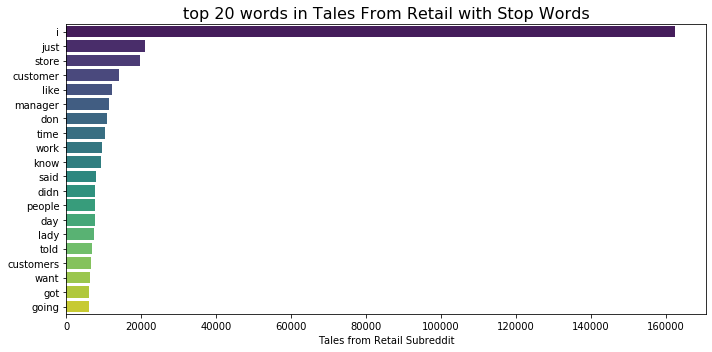

In [52]:
# visualize top 20 words in TalesfromRetails using stop words

plt.figure(figsize = (10, 5))
sns.barplot(x = tales_top_word_stop[0], y = tales_top_word_stop.index, orient = 'h', palette = 'viridis')
plt.title('top 20 words in Tales From Retail with Stop Words', fontsize = 16)
plt.xlabel('Tales from Retail Subreddit')
plt.tight_layout()
plt.savefig('../charts/top_word_tales.png');

The top words definitely look more meaningful than without the stop words. As expected "I" is the most frequent word for both subreddits. Also noticed that "ask(s/ed)", "trump", "man", and "woman" are among the top words in jokes, which makes a lot of sense as we already know that trump-related joke posts are among some of the most popular posts, and also jokes usually generalize characters as man and woman. On the other hand, "store", "customer(s)", "manager" are among the top words for tales which is also easy to explain as the subreddit group is revolved around tales happening in retail space.

### Sentiment Analysis

As part of the preprocessing, I would also like to conduct some sentiment analysis to get the aptitude of each subreddit.

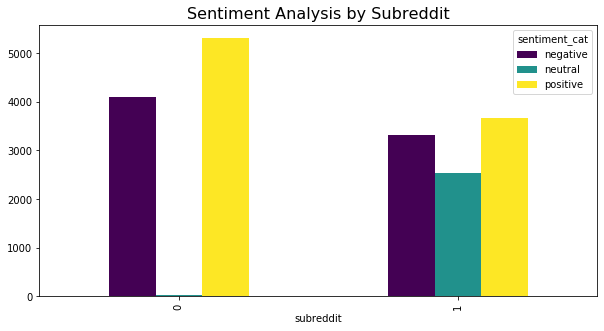

In [65]:
# import sentiment analysis library
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# instantiate
sentiment = SentimentIntensityAnalyzer()

# only shows the compound score for each post
df['sentiment'] = [sentiment.polarity_scores(x)['compound'] for x in df['text']]

# convert the floats to three class: positive, neutral and negative
def pos_or_neg(sent_score):
    if sent_score > 0:
        return 'positive'
    elif sent_score == 0:
        return 'neutral'
    else:
        return 'negative'

# create a new column to map the function
df['sentiment_cat'] = df['sentiment'].map(pos_or_neg)

# plot the bar charts by sentiment scores anc compare between two subreddits
df.groupby(['subreddit', 'sentiment_cat']).count()['text'].unstack().plot(kind = 'bar', 
                                                                          figsize = (10, 5),
                                                                          cmap = 'viridis')
plt.title('Sentiment Analysis by Subreddit', fontsize = 16)
plt.savefig('../charts/sentiment_analysis.png');

As indicated from the above bar chart, sentiment result from Tales subreddit are more emotionally polarized, with very few middle ground; however the Jokes are relatively evenly distributed. Both subreddits have the positive posts as the most sentiment, yet again the number of difference between positive and negatvie posts is greater in Tales from Retail than Jokes.

With the above EDA & preprocessing, I believe I had a relative good idea of the dataset and I'm comfortable to proceed to the next stage -- modeling.